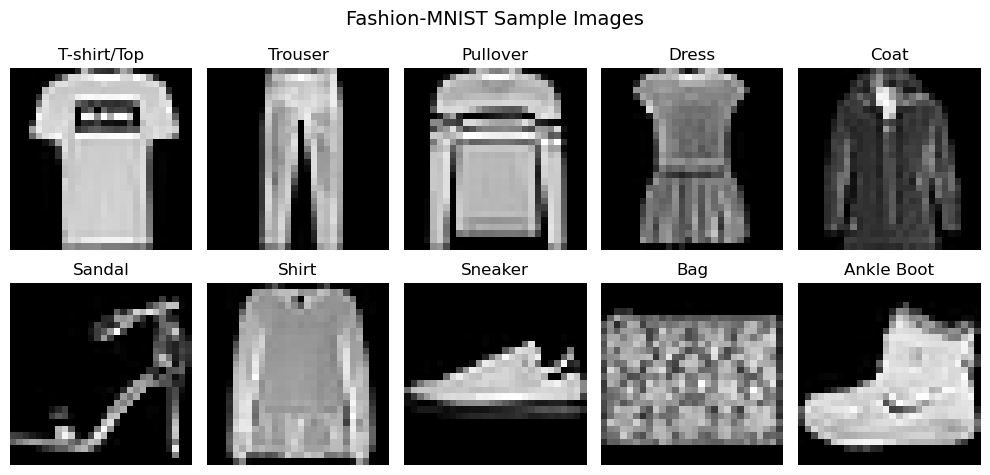

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (_, _) = fashion_mnist.load_data()

class_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

sample_images = []
for i in range(10):
    sample_images.append(x_train[np.where(y_train == i)][0])

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [2]:
pip install wandb



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import wandb
wandb.login()
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/vinodkumar/.netrc


True

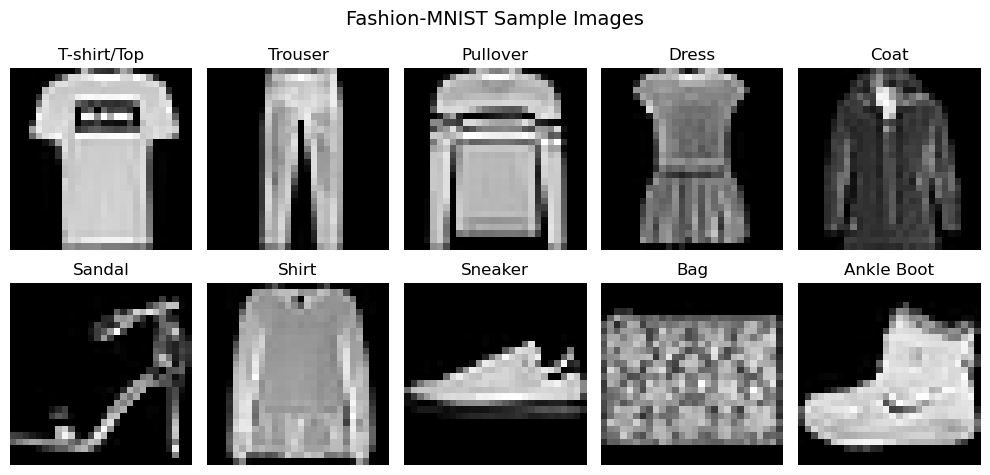

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tensorflow.keras.datasets import fashion_mnist

# Initialize Weights & Biases
wandb.init(project="DA6401_MA23M026_A1")

# Load Fashion-MNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class labels
class_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Find one sample for each class
sample_images = []
for i in range(10):
    sample_images.append(x_train[np.where(y_train == i)][0])

# Log images to Weights & Biases
wandb.log({
    "Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(sample_images, class_labels)]
})

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


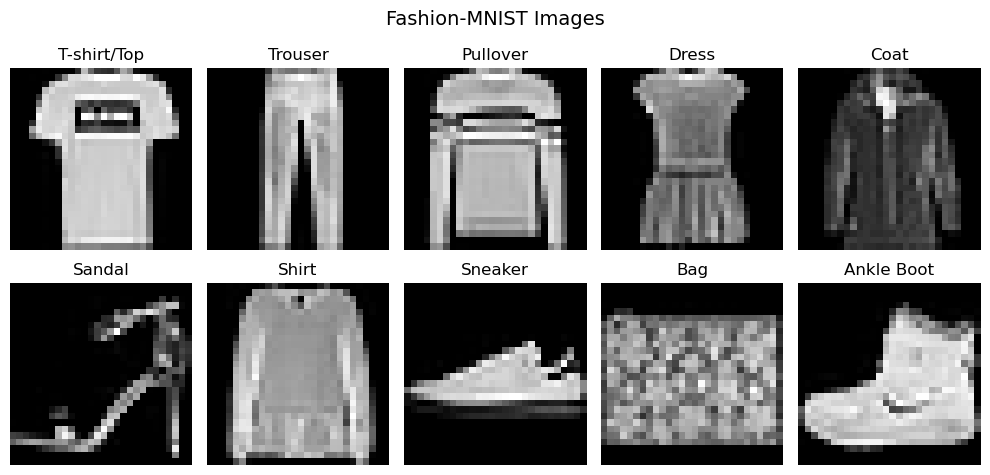

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tensorflow.keras.datasets import fashion_mnist

# Initialize Weights & Biases
wandb.init(project="DA6401_MA23M026_A1")

# Load Fashion-MNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class labels
class_labels = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# Define step and index values
step_value = 3  # Modify this based on your slider value
index_0_value = 35  # Modify this based on your slider value

# Find one sample for each class
sample_images = []
for i in range(10):
    sample_images.append(x_train[np.where(y_train == i)][0])

# Log images along with step and index values to Weights & Biases
wandb.log({
    "Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(sample_images, class_labels)],
    "Step": step_value,
    "Index 0": index_0_value
})

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


### Question -2 

In [5]:
import numpy as np


def sigmoid(z):
  g = 1/(1+np.exp(-z))
  return g

def tanh(z):
  g = np.tanh(z)
  return g

def relu(z):
  return np.maximum(0,z)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def initialize(initializer, size1, size2):
  if(initializer == "random"):
     W = np.random.randn(size1, size2) * 0.01
     return W

  if(initializer == "Xavier"):
     W = np.random.randn(size1, size2) * np.sqrt(1/size2)
     return W

  print("Enter the name of initializer correctly")

def linear_forward(H, W, b):
  W = np.asarray(W)
  H = np.reshape(H,(H.shape[0],-1))
  A = np.dot(W,H) + b 
  cache = (H, W, b)
  
  return A, cache


def initialize_Wb_matrix(X, num_hidden, size_hidden, initializer):
  layer_dims = [X.shape[0]]
  for l in range(0, num_hidden):
    layer_dims.append(size_hidden)
  layer_dims.append(10)   
  np.random.seed(3)
  Wb_matrix = {}
  update = {}
  grads = {}
  L = len(layer_dims)            # number of layers in the network

  for l in range(1,L):
    Wb_matrix['W' + str(l)] = initialize(initializer, layer_dims[l], layer_dims[l-1])
    update['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
    Wb_matrix['b' + str(l)] = np.zeros((layer_dims[l], 1))
    update['b' + str(l)] = np.zeros((layer_dims[l], 1))
    grads['dW' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
    grads['db' + str(l)] = np.zeros((layer_dims[l], 1))
  return Wb_matrix, update, grads


def activation_forward(H_prev, W, b, activation):
  A, linear_cache = linear_forward(H_prev, W, b)
  activation_cache = A
  if activation == 'relu':
    H = relu(A)
  elif activation == 'sigmoid':
    H = sigmoid(A)
  elif activation =='tanh':
    H = tanh(A)
  elif activation == 'softmax':
    H = softmax(A)
  
  return H, activation_cache, linear_cache


def forward_propagation(X, Wb_matrix, activation):
    H = X
    L = int((len(Wb_matrix)/2))
    A_caches = []
    H_caches = [H]
    for l in range(1, L):
        H_prev = H 
        H, A_cache, linear_cache = activation_forward(H_prev, Wb_matrix['W{:d}'.format(l)], Wb_matrix['b{:d}'.format(l)], activation)
        A_caches.append(A_cache)
        H_caches.append(H)
    HL, AL, linear_cache = activation_forward(H, Wb_matrix['W%d' % L], Wb_matrix['b%d' % L], activation='softmax')
    A_caches.append(AL)
    H_caches.append(HL)
    return HL, H_caches, A_caches